# A7: Training Distillation vs LoRA

In [2]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

c:\Users\st124\OneDrive\Desktop\NLP_A7\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('3.4.1', '4.49.0', '2.5.1+cu121')

In [3]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


# 1. Load HateXplain Dataset from Hugging Face

In [ ]:
from datasets import load_dataset

# Load the HateXplain dataset from Hugging Face
dataset = load_dataset("hate_speech_offensive")

# # Check dataset structure
# print(dataset)

c:\Users\st124\OneDrive\Desktop\NLP_A7\venv\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\st124\.cache\huggingface\hub\datasets--hate_speech_offensive. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating train split: 100%|██████████| 24783/24783 [00:00<00:00, 461769.01 examples/s]


In [5]:
# Label Mapping
label_list = ["Non-Hate", "Offensive", "Hate"]
label2id = {v: i for i, v in enumerate(label_list)}
id2label = {i: v for v, i in label2id.items()}

In [6]:
# Assign feature key
task_to_keys = {"hatexplain": "tweet"}
task_name = "hatexplain"
sentence_key = task_to_keys[task_name]

In [9]:
# Print dataset overview
print(dataset)
print("Example:", dataset["train"][0][sentence_key])
print("Label2ID:", label2id)
print("ID2Label:", id2label)

DatasetDict({
    train: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
        num_rows: 24783
    })
})
Example: !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
Label2ID: {'Non-Hate': 0, 'Offensive': 1, 'Hate': 2}
ID2Label: {0: 'Non-Hate', 1: 'Offensive', 2: 'Hate'}


# 2. Tokenization and Data Preprocessing

In [13]:
# Check number of unique labels
num_labels = len(label_list)
num_labels

3

In [14]:
import numpy as np  
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load BERT tokenizer
teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

c:\Users\st124\OneDrive\Desktop\NLP_A7\venv\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\st124\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [15]:
# Load Teacher Model (BERT)
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Tokenization Function (Modified for HateXplain)
def tokenize_function(examples):
    return tokenizer(examples["tweet"], max_length=128, truncation=True, padding="max_length")

In [17]:
# Apply Tokenization
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Remove unnecessary columns
tokenized_datasets = tokenized_datasets.remove_columns(["count", "hate_speech_count", "offensive_language_count", "neither_count", "tweet"])

# Rename "class" column to "labels" for PyTorch compatibility
tokenized_datasets = tokenized_datasets.rename_column("class", "labels")

# Set dataset format for PyTorch
tokenized_datasets.set_format("torch")

# Print an example tokenized input
print(tokenized_datasets["train"][0]["input_ids"])
print(tokenizer.decode(tokenized_datasets["train"][0]["input_ids"]))

Map: 100%|██████████| 24783/24783 [00:02<00:00, 10907.61 examples/s]

tensor([  101,   999,   999,   999, 19387,  1030,  9815, 19454, 21818,  2135,
         1024,  2004,  1037,  2450,  2017,  5807,  1005,  1056, 17612,  2055,
         9344,  2039,  2115,  2160,  1012,  1004, 23713,  1025,  2004,  1037,
         2158,  2017,  2323,  2467,  2202,  1996, 11669,  2041,  1012,  1012,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

# 3. Preparing Dataloader

In [18]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

# Data Collator (Handles Dynamic Padding)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [19]:
# Subset dataset for efficiency
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(10000))  # 10K samples
small_eval_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(1000))    # 1K samples (same train split)
small_test_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(1000))    # 1K samples (same train split)

In [20]:
# Create Dataloaders
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator
)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator
)

In [21]:
# Check first batch
for batch in train_dataloader:
    break

batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 128]), torch.Size([32, 128]))

# 4. Model Training for Even and Odd Layers

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers.models.bert.modeling_bert import BertModel, BertPreTrainedModel, BertConfig
from tqdm.auto import tqdm
import evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get teacher configuration as a dictionary
configuration = teacher_model.config.to_dict()

In [25]:
# Half the number of hidden layers (6 instead of 12)
configuration["num_hidden_layers"] = 6

# Convert dictionary to student configuration
configuration = BertConfig.from_dict(configuration)

In [27]:
# Create uninitialized student models for Odd & Even Layer Training
student_model_odd = type(teacher_model)(configuration)
student_model_even = type(teacher_model)(configuration)

In [28]:
student_model_even

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [31]:
def distill_bert_weights(teacher, student, layer_type="odd"):
    """
    Copies weights from the teacher model to the student model.
    Only copies odd or even layers as specified by `layer_type`.

    layer_type: 'odd' -> {1,3,5,7,9,11} mapped to student {0,1,2,3,4,5}
                'even' -> {2,4,6,8,10,12} mapped to student {0,1,2,3,4,5}
    """
    if isinstance(teacher, BertModel) or isinstance(teacher, BertPreTrainedModel):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, layer_type)

    elif hasattr(teacher, "encoder") and hasattr(student, "encoder"):
        teacher_encoding_layers = list(teacher.encoder.layer)  # 12 layers
        student_encoding_layers = list(student.encoder.layer)  # 6 layers

        if layer_type == "odd":
            selected_layers = [teacher_encoding_layers[i] for i in range(12) if i % 2 == 0]  # {1,3,5,7,9,11}
        else:  # Even layers
            selected_layers = [teacher_encoding_layers[i] for i in range(12) if i % 2 == 1]  # {2,4,6,8,10,12}

        # Ensure correct mapping to student layers
        for i in range(len(student_encoding_layers)):
            student_encoding_layers[i].load_state_dict(selected_layers[i].state_dict())

    elif hasattr(teacher, "pooler") and hasattr(student, "pooler"):
        student.pooler.load_state_dict(teacher.pooler.state_dict())  # Copy pooler weights if present

    return student

    return student

In [32]:
# Apply distillation: Create student models from Odd and Even layers
student_model_odd = distill_bert_weights(teacher_model, student_model_odd, "odd")
student_model_even = distill_bert_weights(teacher_model, student_model_even, "even")

In [33]:
# Apply distillation: Create student models from Odd and Even layers
student_model_odd = distill_bert_weights(teacher_model, student_model_odd, "odd")
student_model_even = distill_bert_weights(teacher_model, student_model_even, "even")

In [34]:
# Move models to device
student_model_odd = student_model_odd.to(device)
student_model_even = student_model_even.to(device)
teacher_model = teacher_model.to(device)

In [35]:
# Print model parameter counts
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Teacher parameters:", count_parameters(teacher_model))
print("Odd Student parameters:", count_parameters(student_model_odd))
print("Even Student parameters:", count_parameters(student_model_even))

# Percentage size reduction
print(f"Odd Student Model Size: {count_parameters(student_model_odd)/count_parameters(teacher_model) * 100:.2f}%")
print(f"Even Student Model Size: {count_parameters(student_model_even)/count_parameters(teacher_model) * 100:.2f}%")

Teacher parameters: 109484547
Odd Student parameters: 66957315
Even Student parameters: 66957315
Odd Student Model Size: 61.16%
Even Student Model Size: 61.16%


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import get_scheduler
from tqdm.auto import tqdm
import evaluate

# Define Distillation Loss
class DistillKL(nn.Module):
    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Computes the KL Divergence Loss between teacher and student model logits.
        '''
        T = temperature
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        return KD_loss

In [37]:
# Loss functions
criterion_cls = nn.CrossEntropyLoss()  # Classification Loss
criterion_div = DistillKL()  # KL Divergence Loss
criterion_cos = nn.CosineEmbeddingLoss()  # Cosine Similarity Loss

In [38]:
# Optimizers
lr = 5e-5
optimizer_odd = optim.Adam(params=student_model_odd.parameters(), lr=lr)
optimizer_even = optim.Adam(params=student_model_even.parameters(), lr=lr)

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

In [39]:
# Learning rate schedulers
lr_scheduler_odd = get_scheduler(
    name="linear", optimizer=optimizer_odd, num_warmup_steps=0, num_training_steps=num_training_steps
)
lr_scheduler_even = get_scheduler(
    name="linear", optimizer=optimizer_even, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [41]:
# Metric for evaluation
metric = evaluate.load("accuracy")

In [42]:
def train_student_model(student_model, optimizer, lr_scheduler, student_type="odd"):
    """
    Trains the student model (Odd or Even) and evaluates it.
    """
    progress_bar = tqdm(range(num_training_steps))
    eval_metrics = 0

    # Lists to store losses for each epoch
    train_losses = []
    train_losses_cls = []
    train_losses_div = []
    train_losses_cos = []
    eval_losses = []

    for epoch in range(num_epochs):
        student_model.train()
        teacher_model.eval()
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0

        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = student_model(**batch)  # Student model predictions

            with torch.no_grad():
                output_teacher = teacher_model(**batch)  # Teacher model predictions

            # Compute Losses
            loss_cls  = criterion_cls(outputs.logits, batch["labels"])  # Classification loss
            loss_div = criterion_div(outputs.logits, output_teacher.logits)  # KL Divergence
            loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))  # Cosine similarity loss

            # Weighted total loss
            loss = (loss_cls + loss_div + loss_cos) / 3

            # Store loss values
            train_loss += loss.item()
            train_loss_cls += loss_cls.item()
            train_loss_div += loss_div.item()
            train_loss_cos += loss_cos.item()

            # Backpropagation
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        train_losses.append(train_loss / len(train_dataloader))
        train_losses_cls.append(train_loss_cls / len(train_dataloader))
        train_losses_div.append(train_loss_div / len(train_dataloader))
        train_losses_cos.append(train_loss_cos / len(train_dataloader))

        print(f'Epoch {epoch+1} ({student_type} student): Train Loss: {train_loss/len(train_dataloader):.4f}')
        print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
        print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
        print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')

        # Evaluate model
        student_model.eval()
        eval_loss = 0

        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = student_model(**batch)

            loss_cls = criterion_cls(outputs.logits, batch["labels"])
            predictions = outputs.logits.argmax(dim=-1)

            eval_loss += loss_cls.item()
            metric.add_batch(predictions=predictions, references=batch["labels"])

        eval_metric = metric.compute()
        eval_metrics += eval_metric["accuracy"]
        eval_losses.append(eval_loss / len(eval_dataloader))  

        print(f"Epoch {epoch+1} ({student_type} student): Test Accuracy: {eval_metric['accuracy']:.4f}")

    print(f'Average Accuracy ({student_type} student): {eval_metrics/num_epochs:.4f}')

In [43]:
# Train Odd-Layer Student Model
print("\n=== Training Odd-Layer Student Model ===")
train_student_model(student_model_odd, optimizer_odd, lr_scheduler_odd, "odd")

# Train Even-Layer Student Model
print("\n=== Training Even-Layer Student Model ===")
train_student_model(student_model_even, optimizer_even, lr_scheduler_even, "even")


=== Training Odd-Layer Student Model ===


 20%|██        | 313/1565 [01:41<06:12,  3.36it/s]

Epoch 1 (odd student): Train Loss: 0.3123
  - Loss_cls: 0.6176
  - Loss_div: 0.1610
  - Loss_cos: 0.1584


 20%|██        | 314/1565 [01:44<19:02,  1.10it/s]

Epoch 1 (odd student): Test Accuracy: 0.9230


 40%|████      | 626/1565 [03:24<04:38,  3.38it/s]

Epoch 2 (odd student): Train Loss: 0.2951
  - Loss_cls: 0.5393
  - Loss_div: 0.1882
  - Loss_cos: 0.1577


 40%|████      | 627/1565 [03:27<14:12,  1.10it/s]

Epoch 2 (odd student): Test Accuracy: 0.9520


 60%|██████    | 939/1565 [05:07<03:05,  3.37it/s]

Epoch 3 (odd student): Train Loss: 0.2867
  - Loss_cls: 0.5082
  - Loss_div: 0.1970
  - Loss_cos: 0.1550


 60%|██████    | 940/1565 [05:09<09:26,  1.10it/s]

Epoch 3 (odd student): Test Accuracy: 0.9700


 80%|████████  | 1252/1565 [06:50<01:33,  3.36it/s]

Epoch 4 (odd student): Train Loss: 0.2784
  - Loss_cls: 0.4836
  - Loss_div: 0.2041
  - Loss_cos: 0.1475


 80%|████████  | 1253/1565 [06:53<04:43,  1.10it/s]

Epoch 4 (odd student): Test Accuracy: 0.9800


100%|██████████| 1565/1565 [08:33<00:00,  3.38it/s]

Epoch 5 (odd student): Train Loss: 0.2731
  - Loss_cls: 0.4695
  - Loss_div: 0.2079
  - Loss_cos: 0.1418


100%|██████████| 1565/1565 [08:35<00:00,  3.03it/s]


Epoch 5 (odd student): Test Accuracy: 0.9820
Average Accuracy (odd student): 0.9614

=== Training Even-Layer Student Model ===


 20%|██        | 313/1565 [01:40<06:10,  3.38it/s]

Epoch 1 (even student): Train Loss: 0.3410
  - Loss_cls: 0.7303
  - Loss_div: 0.1349
  - Loss_cos: 0.1579


 20%|██        | 314/1565 [01:43<18:57,  1.10it/s]

Epoch 1 (even student): Test Accuracy: 0.8560


 40%|████      | 626/1565 [03:23<04:35,  3.40it/s]

Epoch 2 (even student): Train Loss: 0.3089
  - Loss_cls: 0.5939
  - Loss_div: 0.1738
  - Loss_cos: 0.1590


 40%|████      | 627/1565 [03:26<14:12,  1.10it/s]

Epoch 2 (even student): Test Accuracy: 0.8970


 60%|██████    | 939/1565 [05:06<03:06,  3.36it/s]

Epoch 3 (even student): Train Loss: 0.3008
  - Loss_cls: 0.5570
  - Loss_div: 0.1860
  - Loss_cos: 0.1595


 60%|██████    | 940/1565 [05:09<09:29,  1.10it/s]

Epoch 3 (even student): Test Accuracy: 0.9300


 80%|████████  | 1252/1565 [06:49<01:32,  3.37it/s]

Epoch 4 (even student): Train Loss: 0.2928
  - Loss_cls: 0.5240
  - Loss_div: 0.1944
  - Loss_cos: 0.1599


 80%|████████  | 1253/1565 [06:52<04:43,  1.10it/s]

Epoch 4 (even student): Test Accuracy: 0.9510


100%|██████████| 1565/1565 [08:32<00:00,  3.38it/s]

Epoch 5 (even student): Train Loss: 0.2875
  - Loss_cls: 0.5030
  - Loss_div: 0.1996
  - Loss_cos: 0.1598


100%|██████████| 1565/1565 [08:35<00:00,  3.04it/s]

Epoch 5 (even student): Test Accuracy: 0.9590
Average Accuracy (even student): 0.9186


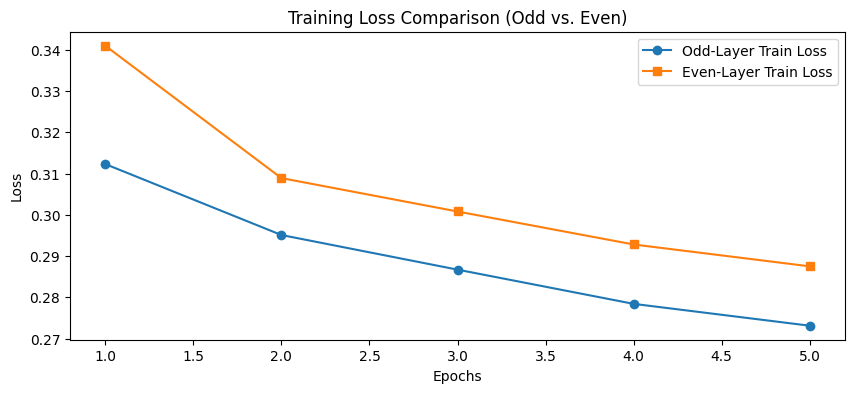

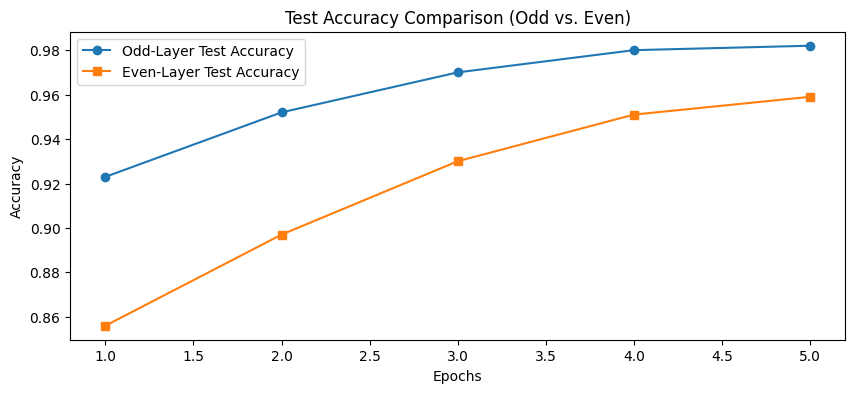

In [45]:
import matplotlib.pyplot as plt

epochs = list(range(1, 6))

# Loss Trend
plt.figure(figsize=(10,4))
plt.plot(epochs, [0.3123, 0.2951, 0.2867, 0.2784, 0.2731], label="Odd-Layer Train Loss", marker="o")
plt.plot(epochs, [0.3410, 0.3089, 0.3008, 0.2928, 0.2875], label="Even-Layer Train Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison (Odd vs. Even)")
plt.legend()
plt.show()

# Accuracy Trend
plt.figure(figsize=(10,4))
plt.plot(epochs, [0.9230, 0.9520, 0.9700, 0.9800, 0.9820], label="Odd-Layer Test Accuracy", marker="o")
plt.plot(epochs, [0.8560, 0.8970, 0.9300, 0.9510, 0.9590], label="Even-Layer Test Accuracy", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Comparison (Odd vs. Even)")
plt.legend()
plt.show()